<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
! pip install --upgrade --no-cache-dir gdown --quiet
! pip install np_utils

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

def plot_dist(frame, key):

  ratings_distribution = frame[key].value_counts().sort_index()
  print(ratings_distribution)

  plt.figure(figsize=(8, 6))
  plt.bar(ratings_distribution.index, ratings_distribution.values)
  plt.xlabel(key)
  plt.ylabel('Count')
  plt.title(f'{key} Distribution')
  plt.show()

  ratings_distribution_pct = (frame[key].value_counts(normalize=True) * 100).sort_index()
  print(ratings_distribution_pct)

1      842
2     1565
3     2871
4     5077
5    13131
Name: Rating, dtype: int64


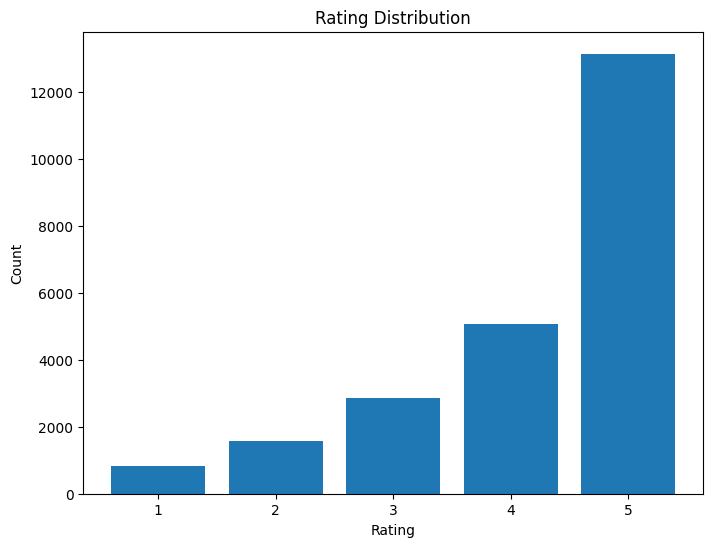

1     3.585115
2     6.663544
3    12.224304
4    21.617134
5    55.909904
Name: Rating, dtype: float64


In [7]:
plot_dist(df, "Rating")

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

reviews = df['Review Text'].values
reviews

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       "This fit well, but the top was very see through. this never would have worked for me. i

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(reviews)

23486

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus

def get_list(series):
    reviews_list = series.tolist()
    reviews_list = [str(text) if not pd.isnull(text) else "" for text in reviews_list]
    return reviews_list

def concat_all(series):
  reviews_list = get_list(series)
  all_reviews_one_string = ' '.join(reviews_list)
  return all_reviews_one_string

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(concat_all(reviews))

7012488

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

all_reviews_one_string = concat_all(reviews)
tokens = text_to_word_sequence(all_reviews_one_string)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

reviews_list = get_list(reviews)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews_list)
sequences = tokenizer.texts_to_sequences(reviews_list)

In [16]:
sequences[0]

[253, 532, 917, 3, 662, 3, 68]

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tokenizer.word_index
len(word_index)

14847

In [18]:
# Alumno: Determinar cual es la oración más larga

def longest_seq(seqs):
  sentence_lengths = [len(sequence) for sequence in seqs]
  index_of_longest_sentence = sentence_lengths.index(max(sentence_lengths))
  longest_sentence = seqs[index_of_longest_sentence]

  print(len(seqs[index_of_longest_sentence]))
  return reviews_list[index_of_longest_sentence]

lgst_seq = longest_seq(sequences)

115


In [19]:
lgst_seq

"I love maeve tops. i love the material and feel of this brand. when i saw the new tops that came out i ran to my local store to try one on. i'm usually a large in a top, once in a while an xl. they only had a large to try so i tried it in the black motif.\ni could barely get the top on. it looked like i was missing 1/2 of the top. i doubled checked the size and it was a large.\nit's a shame, the top is really cute. if you are the least bit broad or busty, go up a size or two. if you are usually a"

In [20]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

max_sequence_length = max([len(sequence) for sequence in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [21]:
# Alumno: Observar las dimensiones de la variable input
padded_sequences.shape

(23486, 115)

In [22]:
X = padded_sequences

In [23]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

import numpy as np
from keras.utils import to_categorical

ratings = df['Rating'].dropna()

# Transforma las calificaciones a representación One-Hot Encoding
y = to_categorical(ratings)

y.shape

(23486, 6)

In [24]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Alumno: determinar la dimensiones de entrada y salida
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]
print(input_shape)
print(output_shape)

115
6


### 2 - Entrenar el modelo con Embeddings + LSTM

In [26]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.

En el primer intento de entrenamiento se utilizaron los datos sin balancear como referencia inicial. Este paso proporciona una base para evaluar la mejora que se espera al utilizar datos balanceados en los experimentos posteriores.

Además, se ha preparado una arquitectura básica de modelo que consta de capas de Embeddings, Dropout, una capa LSTM y una capa fully connected. Este modelo servirá como punto de partida para ;ps experimentos, y a partir de aquí, se realizaran modificaciones y ajustes para lograr mejores resultados.

In [27]:
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dropout, Dense

embedding_dim = 1000

model = Sequential()

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            trainable=True)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units=6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)  # Ajusta los hiperparámetros según tu problema

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
470/470 [==============================] - 59s 99ms/step - loss: 1.2216 - accuracy: 0.5606 - val_loss: 1.2161 - val_accuracy: 0.5599
Epoch 2/10
470/470 [==============================] - 10s 21ms/step - loss: 1.2005 - accuracy: 0.5610 - val_loss: 1.0948 - val_accuracy: 0.5599
Epoch 3/10
470/470 [==============================] - 8s 16ms/step - loss: 0.9699 - accuracy: 0.6150 - val_loss: 0.9223 - val_accuracy: 0.6070
Epoch 4/10
470/470 [==============================] - 7s 15ms/step - loss: 0.8418 - accuracy: 0.6563 - val_loss: 0.8852 - val_accuracy: 0.6307
Epoch 5/10
470/470 [==============================] - 6s 13ms/step - loss: 0.7778 - accuracy: 0.6795 - val_loss: 0.9003 - val_accuracy: 0.6320
Epoch 6/10
470/470 [==============================] - 8s 17ms/step - loss: 0.7200 - accuracy: 0.7063 - val_loss: 0.9447 - val_accuracy: 0.6362
Epoch 7/10
470/470 [==============================] - 6s 13ms/step - loss: 0.6769 - accuracy: 0.7268 - val_loss: 0.9216 - val_accuracy: 0.63

Desde el principio, se ha logrado una precisión en el rango esperado, que oscila entre 0.5 y 0.7, de acuerdo con las expectativas de la consigna. Sin embargo, este resultado posiblemente sea indicativo de un sobreajuste, especialmente debido al desbalance pronunciado en las clases.

A partir de este punto, se mantendrala arquitectura actual del modelo sin cambios significativos. En lugar de eso, se van a realizar dos modificaciones clave: primero, embeddings pre-entrenados en lugar de entrenarlos desde cero, y segundo, trabajar con un dataset balanceado.

La próxima prueba consistirá en emplear la misma arquitectura y proceso de entrenamiento, pero esta vez con el dataset balanceado. Esta estrategia tiene como objetivo abordar el desbalance de clases y potencialmente mejorar la generalización del modelo.

In [28]:
! pip install -U imbalanced-learn


In [29]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=42)

# Perform undersampling with the custom strategy on your dataset
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [30]:
# Count the occurrences of each class label
categorical_labels = np.argmax(y_resampled, axis=1)
unique_classes, class_counts = np.unique(categorical_labels, return_counts=True)

# Create a dictionary to display the class distribution
class_distribution = dict(zip(unique_classes, class_counts))

# Print the class distribution
print("Class Distribution (Class: Count)")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class Distribution (Class: Count)
Class 0: 842 samples
Class 1: 842 samples
Class 2: 842 samples
Class 3: 842 samples
Class 4: 842 samples


In [31]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [32]:
embedding_dim = 1000

model = Sequential()

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            trainable=True)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)  # Ajusta los hiperparámetros según tu problema

loss, accuracy = model.evaluate(X_test_resampled, y_test_resampled)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
85/85 [==============================] - 26s 268ms/step - loss: 1.6147 - accuracy: 0.1901 - val_loss: 1.6114 - val_accuracy: 0.2047
Epoch 2/10
85/85 [==============================] - 12s 133ms/step - loss: 1.6116 - accuracy: 0.2027 - val_loss: 1.6127 - val_accuracy: 0.2047
Epoch 3/10
85/85 [==============================] - 5s 58ms/step - loss: 1.6114 - accuracy: 0.1897 - val_loss: 1.6108 - val_accuracy: 0.1869
Epoch 4/10
85/85 [==============================] - 2s 29ms/step - loss: 1.6101 - accuracy: 0.2071 - val_loss: 1.6102 - val_accuracy: 0.2092
Epoch 5/10
85/85 [==============================] - 3s 31ms/step - loss: 1.6031 - accuracy: 0.2175 - val_loss: 1.6146 - val_accuracy: 0.2047
Epoch 6/10
85/85 [==============================] - 2s 28ms/step - loss: 1.5851 - accuracy: 0.2283 - val_loss: 1.6032 - val_accuracy: 0.2181
Epoch 7/10
85/85 [==============================] - 1s 17ms/step - loss: 1.5597 - accuracy: 0.2569 - val_loss: 1.6031 - val_accuracy: 0.2181
Epoch 8/1

La estrategia de undersampling con el objetivo de lograr un equilibrio perfecto en las clases no resultó efectiva. En su lugar, se va a explorar una aproximación basada en oversampling para abordar el desbalance en los datos.

In [33]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy="auto", random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [34]:
categorical_labels = np.argmax(y_resampled, axis=1)
unique_classes, class_counts = np.unique(categorical_labels, return_counts=True)

class_distribution = dict(zip(unique_classes, class_counts))

print("Class Distribution (Class: Count)")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class Distribution (Class: Count)
Class 0: 13131 samples
Class 1: 13131 samples
Class 2: 13131 samples
Class 3: 13131 samples
Class 4: 13131 samples


In [35]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [36]:
embedding_dim = 1000

model = Sequential()

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            trainable=True)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)  # Ajusta los hiperparámetros según tu problema

loss, accuracy = model.evaluate(X_test_resampled, y_test_resampled)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
1314/1314 [==============================] - 61s 45ms/step - loss: 1.6105 - accuracy: 0.1989 - val_loss: 1.6098 - val_accuracy: 0.2000
Epoch 2/10
1314/1314 [==============================] - 17s 13ms/step - loss: 1.5780 - accuracy: 0.2359 - val_loss: 1.3120 - val_accuracy: 0.4397
Epoch 3/10
1314/1314 [==============================] - 15s 11ms/step - loss: 1.0076 - accuracy: 0.5715 - val_loss: 0.8302 - val_accuracy: 0.6584
Epoch 4/10
1314/1314 [==============================] - 14s 11ms/step - loss: 0.6981 - accuracy: 0.7200 - val_loss: 0.6586 - val_accuracy: 0.7436
Epoch 5/10
1314/1314 [==============================] - 16s 12ms/step - loss: 0.5231 - accuracy: 0.7987 - val_loss: 0.5732 - val_accuracy: 0.7840
Epoch 6/10
1314/1314 [==============================] - 14s 10ms/step - loss: 0.4166 - accuracy: 0.8430 - val_loss: 0.5053 - val_accuracy: 0.8180
Epoch 7/10
1314/1314 [==============================] - 15s 11ms/step - loss: 0.3412 - accuracy: 0.8751 - val_loss: 0.5084 -

Esta estrategia ha logrado resultados satisfactorios en términos de accuracy. Sin embargo, al observar la distribución original de los datos y compararla con la distribución después del oversampling, surge la preocupación de que cada muestra de la clase minoritaria haya sido replicada al menos 13 veces en el conjunto de datos oversampleado. En otras palabras, cada fila de la clase 1 aparece al menos 13 veces en el conjunto de datos oversampleado. Esto plantea la posibilidad de que el sistema esté experimentando un sobreajuste. Además, al tener los mismos datos en los conjuntos de entrenamiento, prueba y validación, es probable que los valores observados no sean tan representativos. Es probable que el sistema haya aprendido de manera exhaustiva todos los ejemplos de la clase 1.

Dado que se han descartado la estrategia de undersampling y existen sospechas sobre la estrategia de oversampling actual, se va a explorar la opción de utilizar SMOTE. Esta aproximación implica el oversampling generando ejemplos sintéticos para cada clase minoritaria. SMOTE se utiliza precisamente en escenarios como este, donde se intenta reducir el posible sobreajuste que puede surgir al utilizar el oversampling aleatorio.

In [37]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [38]:
# Count the occurrences of each class label
categorical_labels = np.argmax(y_resampled, axis=1)
unique_classes, class_counts = np.unique(categorical_labels, return_counts=True)

# Create a dictionary to display the class distribution
class_distribution = dict(zip(unique_classes, class_counts))

# Print the class distribution
print("Class Distribution (Class: Count)")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class Distribution (Class: Count)
Class 0: 13131 samples
Class 1: 13131 samples
Class 2: 13131 samples
Class 3: 13131 samples
Class 4: 13131 samples


In [39]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [40]:
embedding_dim = 1000

model = Sequential()

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            trainable=True)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)  # Ajusta los hiperparámetros según tu problema

loss, accuracy = model.evaluate(X_test_resampled, y_test_resampled)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
1314/1314 [==============================] - 43s 31ms/step - loss: 1.6107 - accuracy: 0.2051 - val_loss: 1.6097 - val_accuracy: 0.2033
Epoch 2/10
1314/1314 [==============================] - 16s 12ms/step - loss: 1.6095 - accuracy: 0.2014 - val_loss: 1.6094 - val_accuracy: 0.2004
Epoch 3/10
1314/1314 [==============================] - 15s 11ms/step - loss: 1.6094 - accuracy: 0.2003 - val_loss: 1.6106 - val_accuracy: 0.1943
Epoch 4/10
1314/1314 [==============================] - 14s 11ms/step - loss: 1.4560 - accuracy: 0.3183 - val_loss: 1.3401 - val_accuracy: 0.3651
Epoch 5/10
1314/1314 [==============================] - 26s 20ms/step - loss: 1.2814 - accuracy: 0.3855 - val_loss: 1.2870 - val_accuracy: 0.3832
Epoch 6/10
1314/1314 [==============================] - 15s 12ms/step - loss: 1.2259 - accuracy: 0.4084 - val_loss: 1.2746 - val_accuracy: 0.3746
Epoch 7/10
1314/1314 [==============================] - 16s 12ms/step - loss: 1.1906 - accuracy: 0.4271 - val_loss: 1.2638 -

SMOTE tampoco logra resultados óptimos. La próxima mejor aproximación es la de no buscar un equilibrio completo entre las clases, sino más bien reducir la brecha entre la clase con más muestras y la de menor cantidad. Por ejemplo, duplicar o triplicar las entradas de la clase 1 y posiblemente también de la clase 2. Esta estrategia permite evitar el sobreajuste y, al mismo tiempo, mantener una relación más cercana a la distribución original de clases.

In [41]:
oversampler = SMOTE(sampling_strategy = {1: 842*3, 2:1565*2, 3: 2871*2}, random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [42]:
# Count the occurrences of each class label
categorical_labels = np.argmax(y_resampled, axis=1)
unique_classes, class_counts = np.unique(categorical_labels, return_counts=True)

# Create a dictionary to display the class distribution
class_distribution = dict(zip(unique_classes, class_counts))

# Print the class distribution
print("Class Distribution (Class: Count)")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class Distribution (Class: Count)
Class 0: 2526 samples
Class 1: 3130 samples
Class 2: 5742 samples
Class 3: 5077 samples
Class 4: 13131 samples


In [43]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [44]:
embedding_dim = 1000

model = Sequential()

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            trainable=True)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)  # Ajusta los hiperparámetros según tu problema

loss, accuracy = model.evaluate(X_test_resampled, y_test_resampled)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
593/593 [==============================] - 35s 54ms/step - loss: 1.4346 - accuracy: 0.4427 - val_loss: 1.4414 - val_accuracy: 0.4374
Epoch 2/10
593/593 [==============================] - 9s 15ms/step - loss: 1.4292 - accuracy: 0.4433 - val_loss: 1.4410 - val_accuracy: 0.4372
Epoch 3/10
593/593 [==============================] - 9s 15ms/step - loss: 1.3922 - accuracy: 0.4493 - val_loss: 1.3016 - val_accuracy: 0.4898
Epoch 4/10
593/593 [==============================] - 8s 14ms/step - loss: 1.1785 - accuracy: 0.5408 - val_loss: 1.0967 - val_accuracy: 0.5596
Epoch 5/10
593/593 [==============================] - 7s 11ms/step - loss: 1.0158 - accuracy: 0.5835 - val_loss: 1.0533 - val_accuracy: 0.5577
Epoch 6/10
593/593 [==============================] - 7s 13ms/step - loss: 0.9213 - accuracy: 0.6113 - val_loss: 1.0649 - val_accuracy: 0.5598
Epoch 7/10
593/593 [==============================] - 7s 11ms/step - loss: 0.8625 - accuracy: 0.6342 - val_loss: 1.0218 - val_accuracy: 0.584

Finalmente, al establecer una relación más holística entre las clases y utilizar SMOTE para crear un conjunto de datos más equilibrado, se obtuvieron resultados ligeramente inferiores en comparación con el entrenamiento sin balanceo. Un aspecto a considerar es que, al lograr un equilibrio en el conjunto de datos y utilizar datos sintéticos para lograrlo, es más probable que el modelo sea útil en escenarios del mundo real.

El modelo entrenado con el conjunto de datos desequilibrado corre el riesgo de tomar decisiones sesgadas, ya que al predecir la clase mayoritaria, tiene más del 50% de probabilidad de estar en lo correcto. Por otro lado, el modelo con datos balanceados es probablemente menos agresivo en sus predicciones, lo que podría resultar en una mayor generalización y aplicabilidad en situaciones del mundo real.

El proximo paso es entrenar con datos no balanceados y con datos balanceados holisticamente con SMOTE utilizando embeddings pre-entrenados.

In [45]:
! pip install gensim

Se utilizo gensim por la facilidad de su uso y para probar otra herramienta ademas de la vista en clase.

In [46]:
from gensim.models import KeyedVectors
import gensim.downloader as api

# Download and load a pre-trained Word2Vec model (e.g., 'word2vec-google-news-300')
word2vec_model = api.load('word2vec-google-news-300')

In [47]:
from gensim.models import Word2Vec

vocab_size = len(word2vec_model.key_to_index)
embedding_dim = word2vec_model.vector_size

model = Sequential()

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

loss, accuracy = model.evaluate(X_test_resampled, y_test_resampled)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
593/593 [==============================] - 13s 14ms/step - loss: 1.4341 - accuracy: 0.4423 - val_loss: 1.4398 - val_accuracy: 0.4374
Epoch 2/10
593/593 [==============================] - 9s 15ms/step - loss: 1.4305 - accuracy: 0.4432 - val_loss: 1.4395 - val_accuracy: 0.4374
Epoch 3/10
593/593 [==============================] - 11s 19ms/step - loss: 1.4296 - accuracy: 0.4432 - val_loss: 1.4392 - val_accuracy: 0.4374
Epoch 4/10
593/593 [==============================] - 9s 16ms/step - loss: 1.4287 - accuracy: 0.4432 - val_loss: 1.4397 - val_accuracy: 0.4374
Epoch 5/10
593/593 [==============================] - 5s 9ms/step - loss: 1.4288 - accuracy: 0.4432 - val_loss: 1.4405 - val_accuracy: 0.4374
Epoch 6/10
593/593 [==============================] - 6s 10ms/step - loss: 1.4285 - accuracy: 0.4432 - val_loss: 1.4395 - val_accuracy: 0.4374
Epoch 7/10
593/593 [==============================] - 5s 9ms/step - loss: 1.4287 - accuracy: 0.4432 - val_loss: 1.4396 - val_accuracy: 0.4374

Este resultado parece ser negativo, ya que con embeddings pre-entrenados no se ha logrado mejorar la precisión ni en el conjunto de entrenamiento ni en el de validación. Esto podría deberse a una limitación que discutimos en clase: los embeddings pre-entrenados pueden tener dificultades para capturar de manera precisa la información relativa a los adjetivos, ya que su contexto puede hacer que estos términos sean muy similares en la representación vectorial.

En resumen, un modelo entrenado utilizando la técnica de oversampling mediante SMOTE, junto con una estrategia custom para el balanceo de las clases, ha generado resultados satisfactorios, minimizando posibles problemas de overfitting.